In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import multirecording_spikeanalysis as spike

cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)
        

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'test'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 92 is unsorted & has 2494 spikes
Unit 92 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec
Please assign event dictionaries to each recording
as recording.event_dict
event_dict = {event name(str): np.array[[start(ms), stop(ms)]...]
Please assign subjects to each recording as recording.subject


In [2]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data)

All set to analyze


C:\Users\short\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Unit 9 has NaN or zero sigma, skipping.
Unit 24 has NaN or zero sigma, skipping.
Unit 76 has NaN or zero sigma, skipping.
Unit 10 has NaN or zero sigma, skipping.
Unit 94 has NaN or zero sigma, skipping.
Unit 87 has NaN or zero sigma, skipping.
Unit 1 has NaN or zero sigma, skipping.
Unit 15 has NaN or zero sigma, skipping.
Unit 97 has NaN or zero sigma, skipping.
Unit 39 has NaN or zero sigma, skipping.
Unit 2 has NaN or zero sigma, skipping.
Unit 11 has NaN or zero sigma, skipping.
Unit 77 has NaN or zero sigma, skipping.


C:\Users\short\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Skipping population plot for 20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec due to insufficient data.


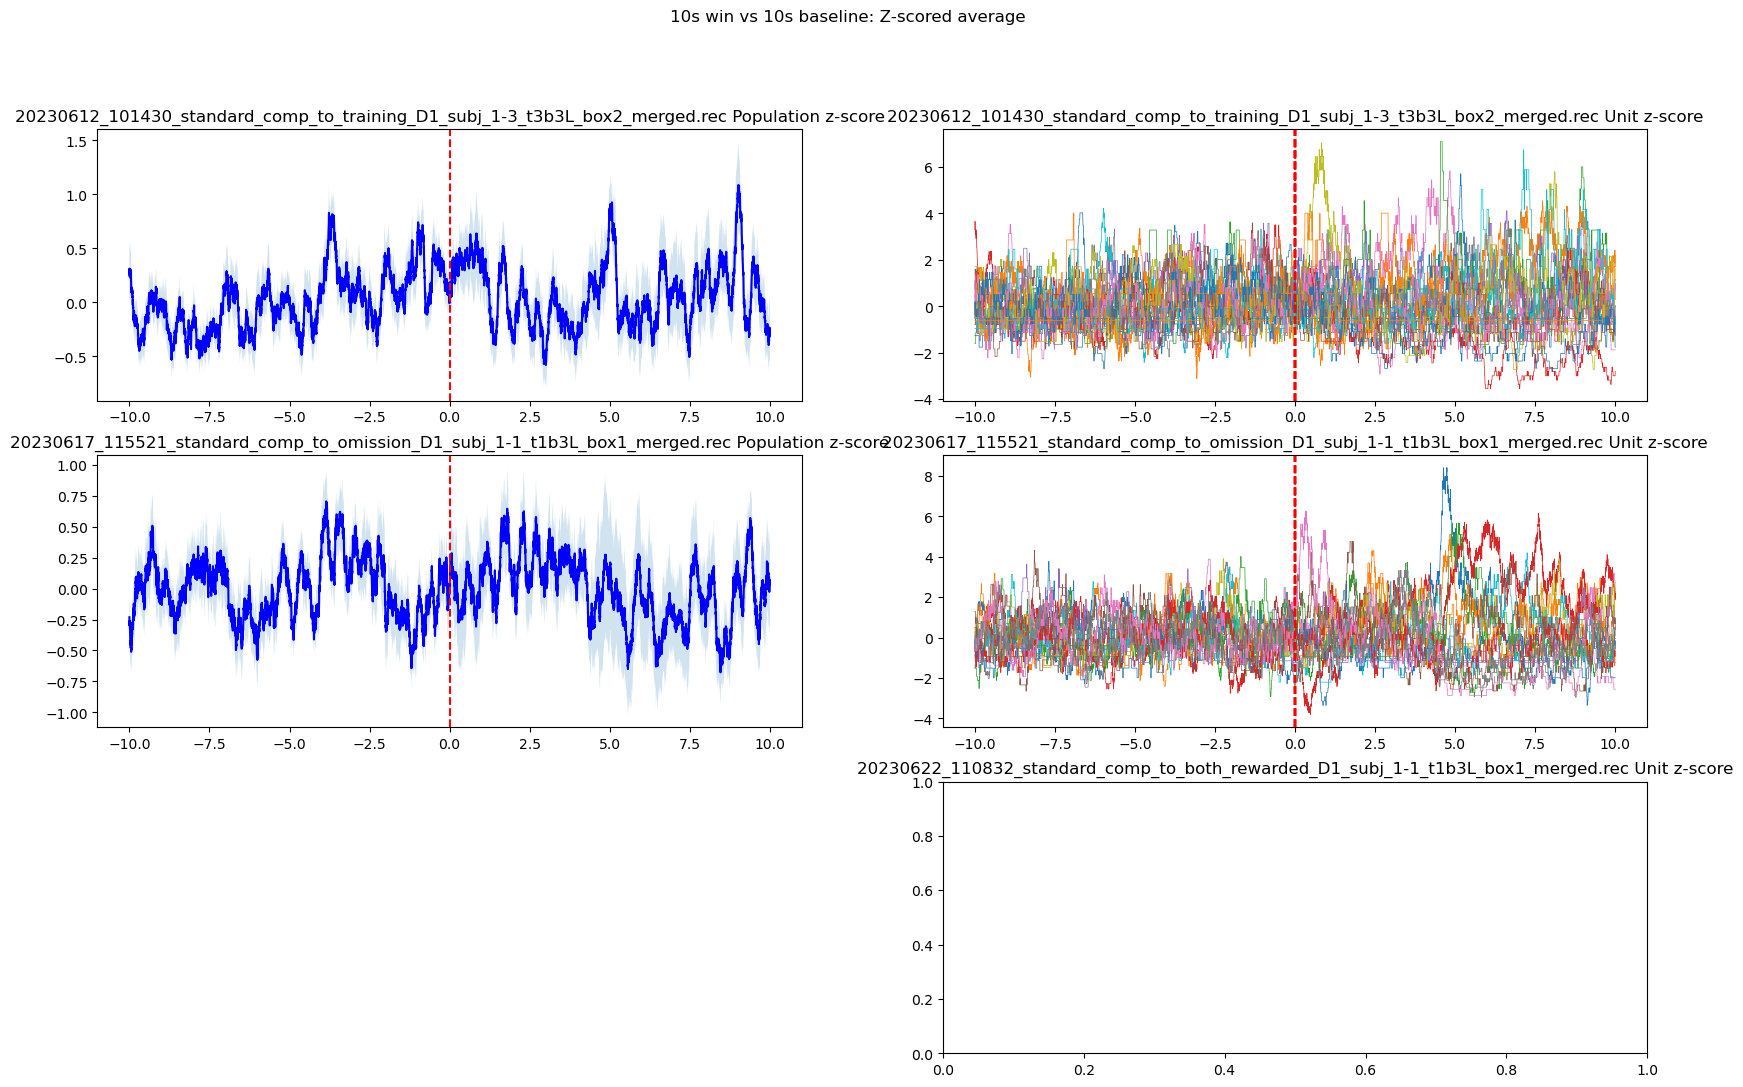

In [3]:
spike_analysis.zscore_pre_event('win',10,10)

C:\Users\short\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=a

Unit 9 has NaN or zero sigma, skipping.
Unit 24 has NaN or zero sigma, skipping.
Unit 76 has NaN or zero sigma, skipping.
Unit 10 has NaN or zero sigma, skipping.
Unit 94 has NaN or zero sigma, skipping.
Unit 87 has NaN or zero sigma, skipping.
Unit 1 has NaN or zero sigma, skipping.
Unit 15 has NaN or zero sigma, skipping.
Unit 97 has NaN or zero sigma, skipping.
Unit 39 has NaN or zero sigma, skipping.
Unit 2 has NaN or zero sigma, skipping.
Unit 11 has NaN or zero sigma, skipping.
Unit 77 has NaN or zero sigma, skipping.
Skipping population plot for 20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec due to insufficient data.


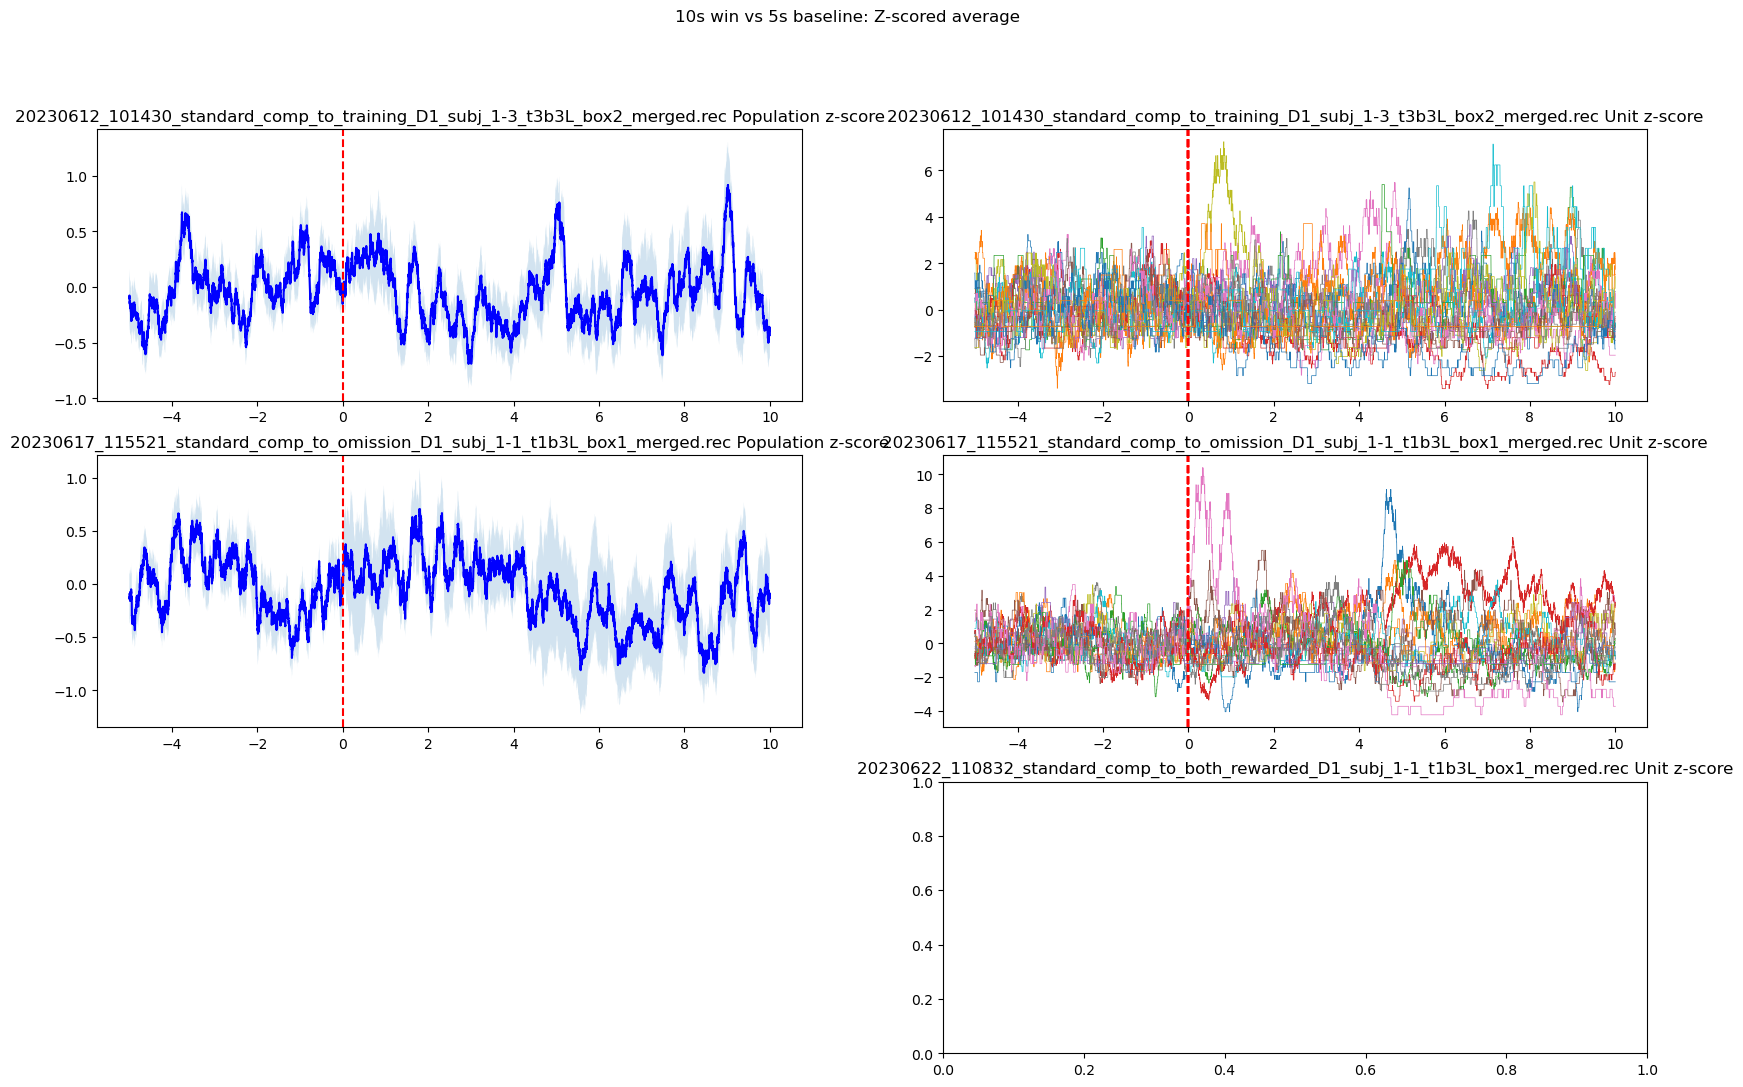

In [4]:
spike_analysis.zscore_pre_event('win',10,5)

C:\Users\short\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Unit 9 has NaN or zero sigma, skipping.
Unit 24 has NaN or zero sigma, skipping.
Unit 76 has NaN or zero sigma, skipping.
Unit 10 has NaN or zero sigma, skipping.
Unit 94 has NaN or zero sigma, skipping.
Unit 87 has NaN or zero sigma, skipping.
Unit 1 has NaN or zero sigma, skipping.
Unit 15 has NaN or zero sigma, skipping.
Unit 97 has NaN or zero sigma, skipping.
Unit 39 has NaN or zero sigma, skipping.
Unit 2 has NaN or zero sigma, skipping.
Unit 11 has NaN or zero sigma, skipping.
Unit 77 has NaN or zero sigma, skipping.


C:\Users\short\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Skipping population plot for 20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec due to insufficient data.


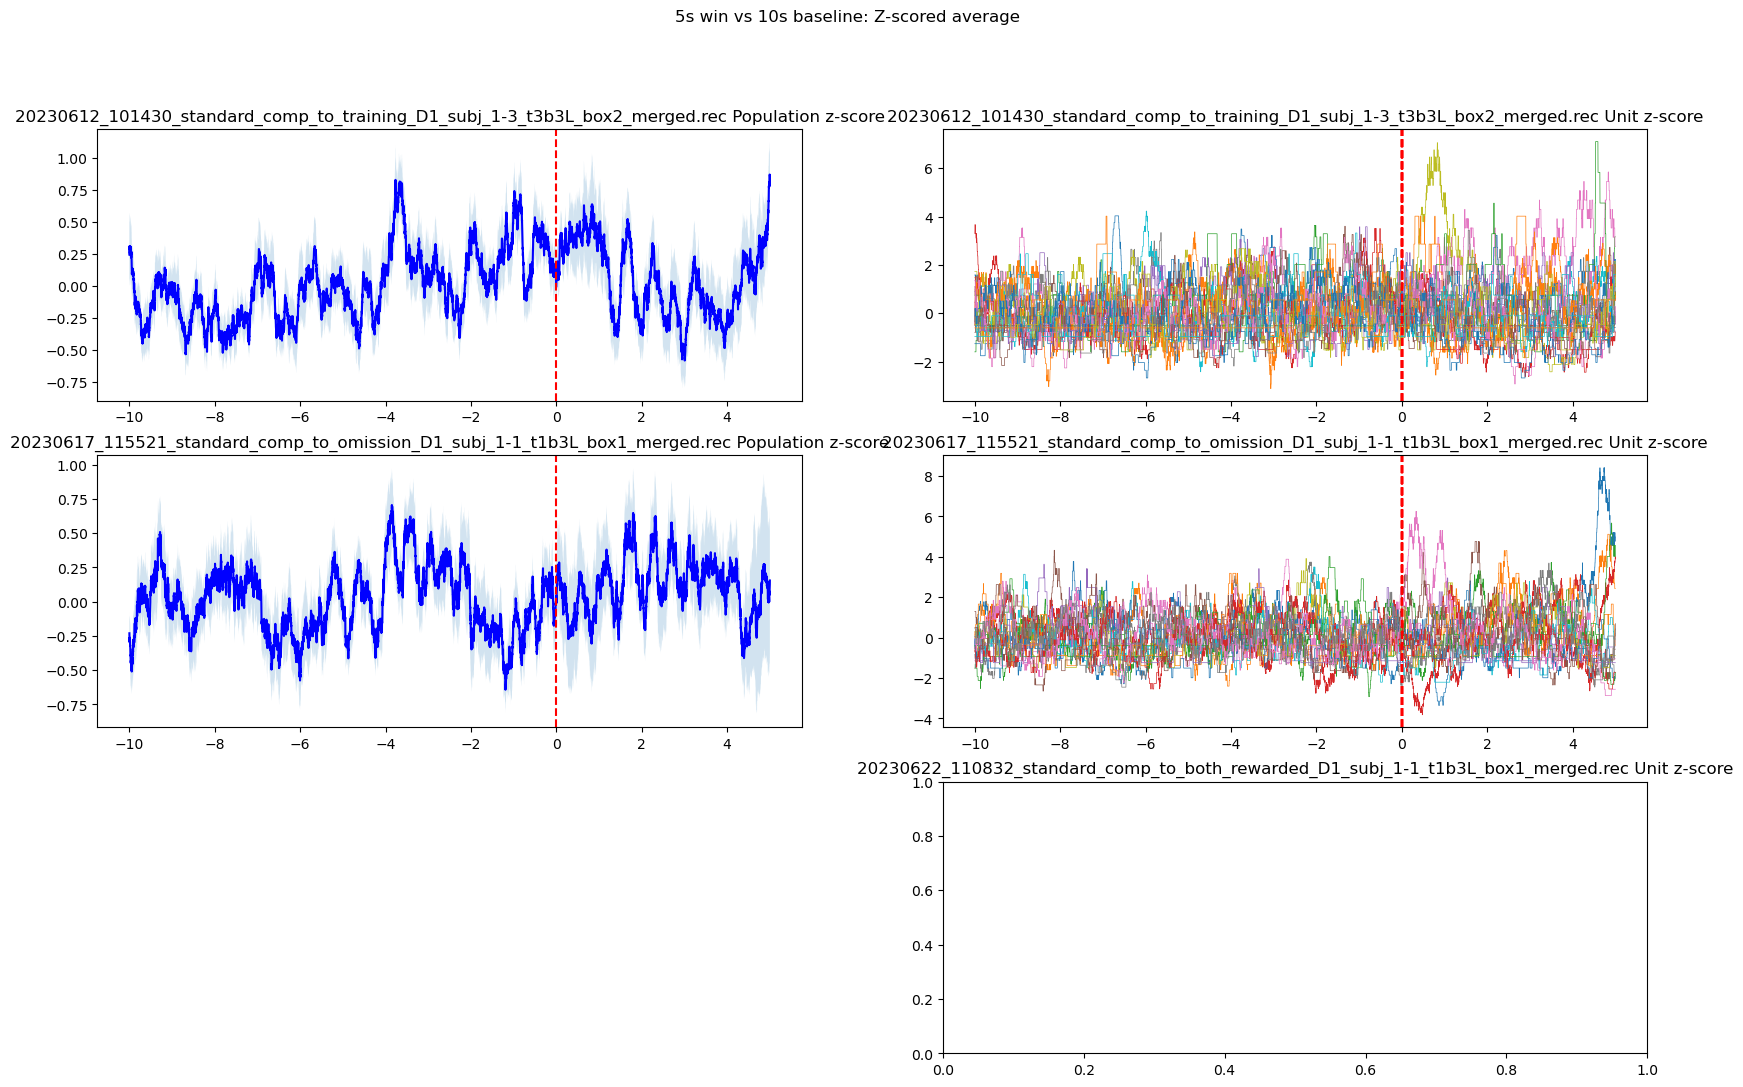

In [5]:
spike_analysis.zscore_pre_event('win',5,10)

C:\Users\short\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=a

Unit 9 has NaN or zero sigma, skipping.
Unit 24 has NaN or zero sigma, skipping.
Unit 76 has NaN or zero sigma, skipping.
Unit 10 has NaN or zero sigma, skipping.
Unit 94 has NaN or zero sigma, skipping.
Unit 87 has NaN or zero sigma, skipping.
Unit 1 has NaN or zero sigma, skipping.
Unit 15 has NaN or zero sigma, skipping.
Unit 97 has NaN or zero sigma, skipping.
Unit 39 has NaN or zero sigma, skipping.
Unit 2 has NaN or zero sigma, skipping.
Unit 11 has NaN or zero sigma, skipping.
Unit 77 has NaN or zero sigma, skipping.
Skipping population plot for 20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec due to insufficient data.


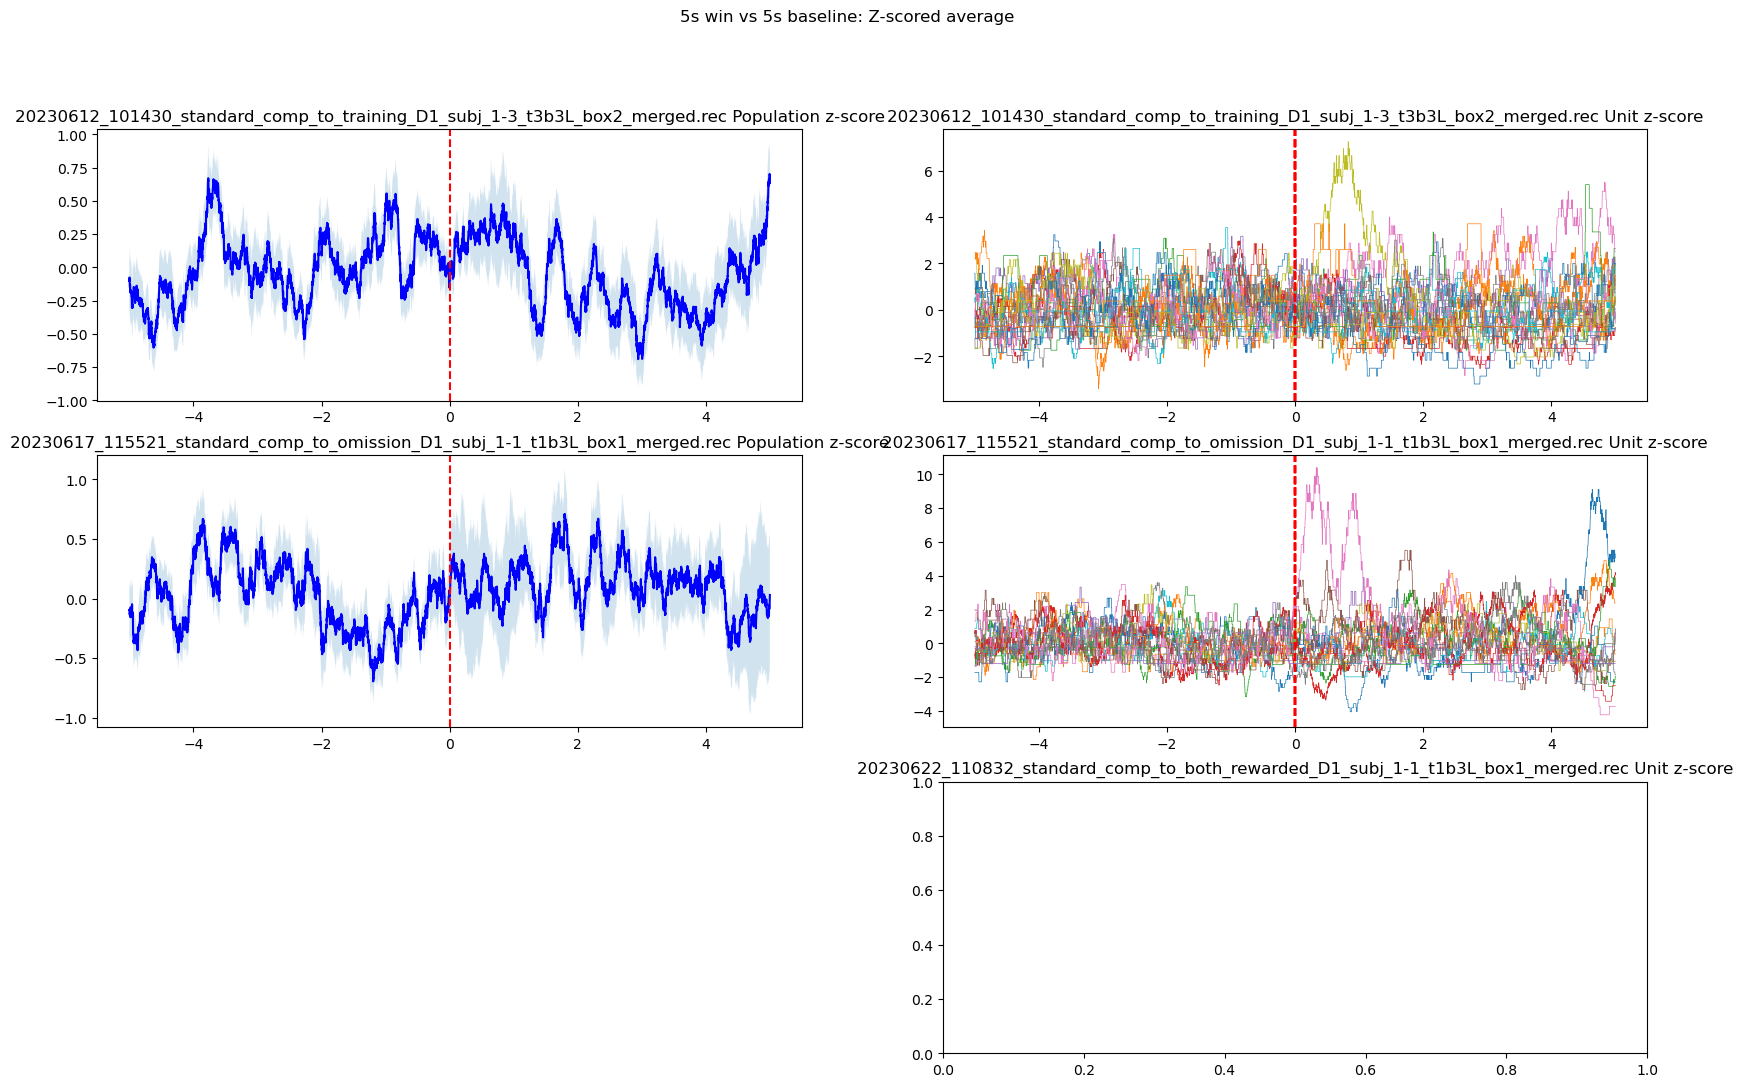

In [6]:
spike_analysis.zscore_pre_event(event='win', equalize=5, baseline_window=5, offset = 0)

C:\Users\short\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Unit 9 has NaN or zero sigma, skipping.
Unit 24 has NaN or zero sigma, skipping.
Unit 76 has NaN or zero sigma, skipping.
Unit 10 has NaN or zero sigma, skipping.
Unit 94 has NaN or zero sigma, skipping.
Unit 87 has NaN or zero sigma, skipping.
Unit 1 has NaN or zero sigma, skipping.
Unit 15 has NaN or zero sigma, skipping.
Unit 97 has NaN or zero sigma, skipping.
Unit 39 has NaN or zero sigma, skipping.
Unit 2 has NaN or zero sigma, skipping.
Unit 11 has NaN or zero sigma, skipping.
Unit 77 has NaN or zero sigma, skipping.


C:\Users\short\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Skipping population plot for 20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec due to insufficient data.


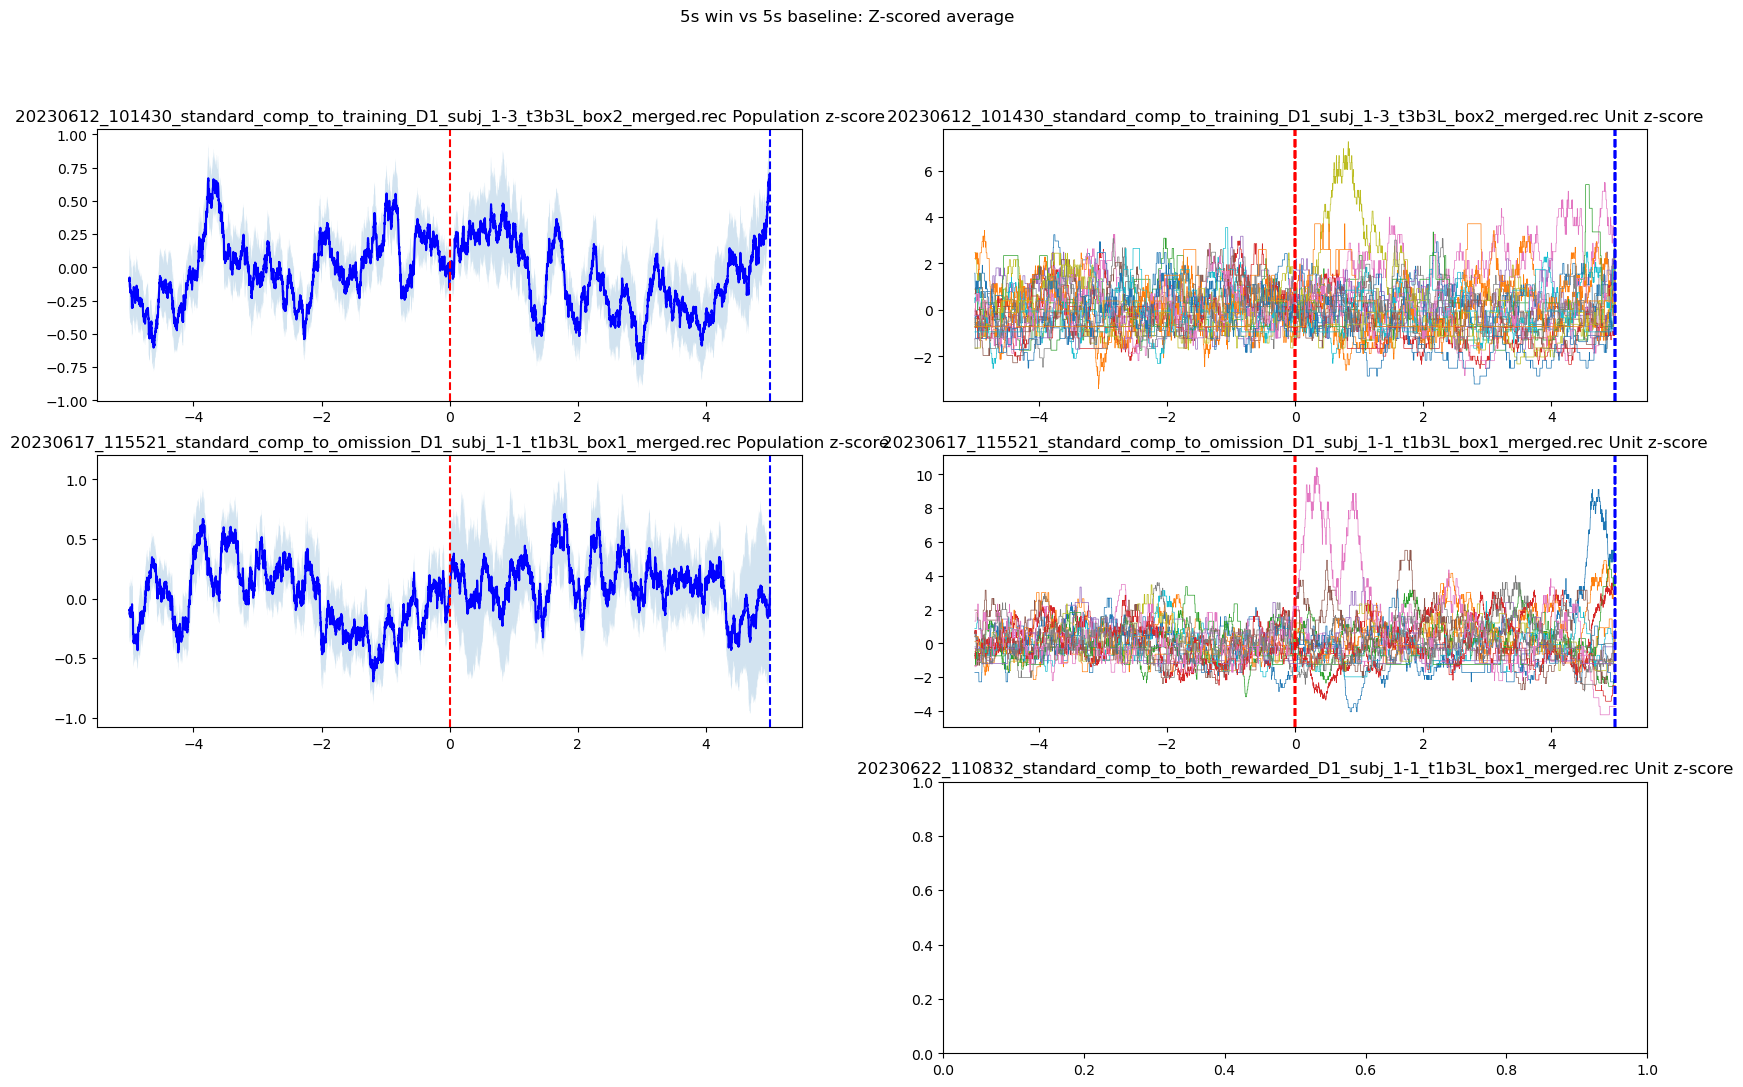

In [7]:
spike_analysis.zscore_pre_event(event='win', equalize=5, baseline_window=5, offset = 5)

In [10]:
for recording in ephys_data.collection.keys():
    print(recording)

20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec


In [11]:
recording1 = ephys_data.collection['20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec']
recording2 = ephys_data.collection['20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec']
recording3 = ephys_data.collection['20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec']

In [12]:
recording1.event_dict

{'rewarded': array([[1849109, 1859109],
        [1909109, 1919109],
        [1964109, 1974109],
        [2029109, 2039109],
        [2084109, 2094109],
        [2134109, 2144109],
        [2184109, 2194109],
        [2289109, 2299109],
        [2409109, 2419109],
        [2529109, 2539109],
        [2639109, 2649109],
        [2724109, 2734109],
        [2844109, 2854109],
        [2904109, 2914109],
        [2969109, 2979109],
        [3029109, 3039109],
        [3104108, 3114109],
        [3204108, 3214109],
        [3299108, 3309108],
        [3349108, 3359108]], dtype=int64),
 'win': array([[ 169111,  179111],
        [ 479111,  489111],
        [ 649110,  659110],
        [ 754110,  764110],
        [ 804110,  814110],
        [ 884110,  894110],
        [ 949110,  959110],
        [1014110, 1024110],
        [1134110, 1144110],
        [1309110, 1319110],
        [1379110, 1389110],
        [1489110, 1499110],
        [1549110, 1559110]], dtype=int64),
 'lose': array([[  49111,  

In [13]:
recording2.event_dict

{'rewarded': array([], dtype=int64),
 'win': array([[ 171543,  181543],
        [ 286544,  296544],
        [ 431544,  441543],
        [ 481543,  491543],
        [ 576543,  586543],
        [ 651543,  661543],
        [ 756543,  766543],
        [ 806543,  816543],
        [ 886543,  896543],
        [ 951543,  961543],
        [1016543, 1026543],
        [1066543, 1076543],
        [1136543, 1146543],
        [1231543, 1241543],
        [1629023, 1639023],
        [1709023, 1719023],
        [1779023, 1789023],
        [1889023, 1899023],
        [1949023, 1959023]], dtype=int64),
 'lose': array([[ 51543,  61543],
        [376543, 386543]], dtype=int64),
 'omission': array([], dtype=int64),
 'both_rewarded': array([], dtype=int64),
 'tie': array([], dtype=int64)}

In [14]:
recording3.event_dict

{'rewarded': array([], dtype=int64),
 'win': array([], dtype=int64),
 'lose': array([[  56560,   66560],
        [ 176561,  186561],
        [ 291562,  301563],
        [ 381564,  391564],
        [ 436564,  446564],
        [ 486565,  496565],
        [ 581566,  591566],
        [ 656567,  666567],
        [ 761568,  771568],
        [ 811569,  821569],
        [ 891570,  901570],
        [ 956571,  966571],
        [1021572, 1031572],
        [1071572, 1081572],
        [1141573, 1151573],
        [1236574, 1246574],
        [1316575, 1326575],
        [1386576, 1396576],
        [1496578, 1506578],
        [1556578, 1566578]], dtype=int64),
 'omission': array([], dtype=int64),
 'both_rewarded': array([[2036584, 2046584],
        [2096585, 2106585],
        [2151586, 2161586],
        [2216587, 2226587],
        [2271587, 2281587],
        [2321588, 2331588],
        [2371589, 2381589],
        [2476590, 2486590],
        [2596591, 2606592],
        [2716593, 2726593],
        [28265

In [15]:
recording1.event_dict['win']

array([[ 169111,  179111],
       [ 479111,  489111],
       [ 649110,  659110],
       [ 754110,  764110],
       [ 804110,  814110],
       [ 884110,  894110],
       [ 949110,  959110],
       [1014110, 1024110],
       [1134110, 1144110],
       [1309110, 1319110],
       [1379110, 1389110],
       [1489110, 1499110],
       [1549110, 1559110]], dtype=int64)

In [16]:
import math

event = 'win'
pre_window=0
post_window=0
equalize=10
timebin=1

if type(event) is str:
    events = recording3.event_dict[event]
else:
    events = event
event_snippets = []
pre_window = math.ceil(pre_window * 1000)
post_window = math.ceil(post_window * 1000)
equalize = equalize * 1000
e_length = equalize + post_window + pre_window
for i in range(events.shape[0]):
    pre_event = math.ceil((events[i][0] - pre_window) / timebin)
    post_event = math.ceil(
        (events[i][0] + post_window + equalize) / timebin
    )
    if len(recording1.event_dict[event].shape) == 1:
        event_snippet = recording3[pre_event:post_event]
        if len(event_snippet) == e_length / timebin:
            # cutting events at end of recording
            event_snippets.append(event_snippet)
    else:
        event_snippet = recording3.event_dict[event][:, pre_event:post_event]
        if event_snippet.shape[1] == e_length / timebin:
            event_snippets.append(event_snippet)

In [17]:
recording1.event_dict['win'].shape[0]

13

In [19]:
# OG Script
def __get_event_snippets__(
    self,
    recording,
    event,
    whole_recording,
    equalize,
    pre_window=0,
    post_window=0,
):
    """
    takes snippets of spiketrains or firing rates for events
    optional pre-event and post-event windows (s) may be included
    all events can also be of equal length by extending
    snippet lengths to the longest event

    Args (6 total, 4 required):
        recording: EphysRecording instance, recording to get snippets
        event: str, event type of which ehpys snippets happen during
        whole_recording: numpy array, spiketrain or firing rates
            for the whole recording, for population or for a single unit
        equalize: float, length (s) of events used by padding with post
            event time or trimming events all to equalize (s) long
        pre_window: int, default=0, seconds prior to start of event
        post_window: int, default=0, seconds after end of event
        
    Returns (1):
        event_snippets: a list of lists, where each list is a list of
            firing rates or spiketrains during an event including 
            pre_window & post_windows, accounting for equalize and 
            timebins for a single unit or for the population returning
            a list of numpy arrays
    """
    if type(event) is str:
        events = recording.event_dict[event]
    else:
        events = event
    event_snippets = []
    pre_window = math.ceil(pre_window * 1000)
    post_window = math.ceil(post_window * 1000)
    equalize = equalize * 1000
    e_length = equalize + post_window + pre_window
    for i in range(events.shape[0]):
        pre_event = math.ceil((events[i][0] - pre_window) / self.timebin)
        post_event = math.ceil(
            (events[i][0] + post_window + equalize) / self.timebin
        )
        if len(whole_recording.shape) == 1:
            event_snippet = whole_recording[pre_event:post_event]
            if len(event_snippet) == e_length / self.timebin:
                # cutting events at end of recording
                event_snippets.append(event_snippet)
        else:
            event_snippet = whole_recording[:, pre_event:post_event]
            if event_snippet.shape[1] == e_length / self.timebin:
                event_snippets.append(event_snippet)
    return event_snippets

In [20]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import multirecording_spikeanalysis_edit2 as spike2

cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)
        

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'test'

ephys_data2 = spike2.EphysRecordingCollection(str(ephys_path))

ModuleNotFoundError: No module named 'multirecording_spikeanalysis_edit2'

In [21]:
for recording in ephys_data2.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data2.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data2.collection[recording].subject = subject
        
spike_analysis2 = spike2.SpikeAnalysis_MultiRecording(ephys_data2)

NameError: name 'ephys_data2' is not defined

In [22]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import multirecording_spikeanalysis as spike

cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)
        

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'test'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 92 is unsorted & has 2494 spikes
Unit 92 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec
Please assign event dictionaries to each recording
as recording.event_dict
event_dict = {event name(str): np.array[[start(ms), stop(ms)]...]
Please assign subjects to each recording as recording.subject


In [24]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


C:\Users\short\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Unit 9 has NaN or zero sigma, skipping.
Unit 24 has NaN or zero sigma, skipping.
Unit 76 has NaN or zero sigma, skipping.
Unit 10 has NaN or zero sigma, skipping.
Unit 94 has NaN or zero sigma, skipping.
Unit 87 has NaN or zero sigma, skipping.
Unit 1 has NaN or zero sigma, skipping.
Unit 15 has NaN or zero sigma, skipping.
Unit 97 has NaN or zero sigma, skipping.
Unit 39 has NaN or zero sigma, skipping.
Unit 2 has NaN or zero sigma, skipping.
Unit 11 has NaN or zero sigma, skipping.
Unit 77 has NaN or zero sigma, skipping.


C:\Users\short\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Skipping population plot for 20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec due to insufficient data.


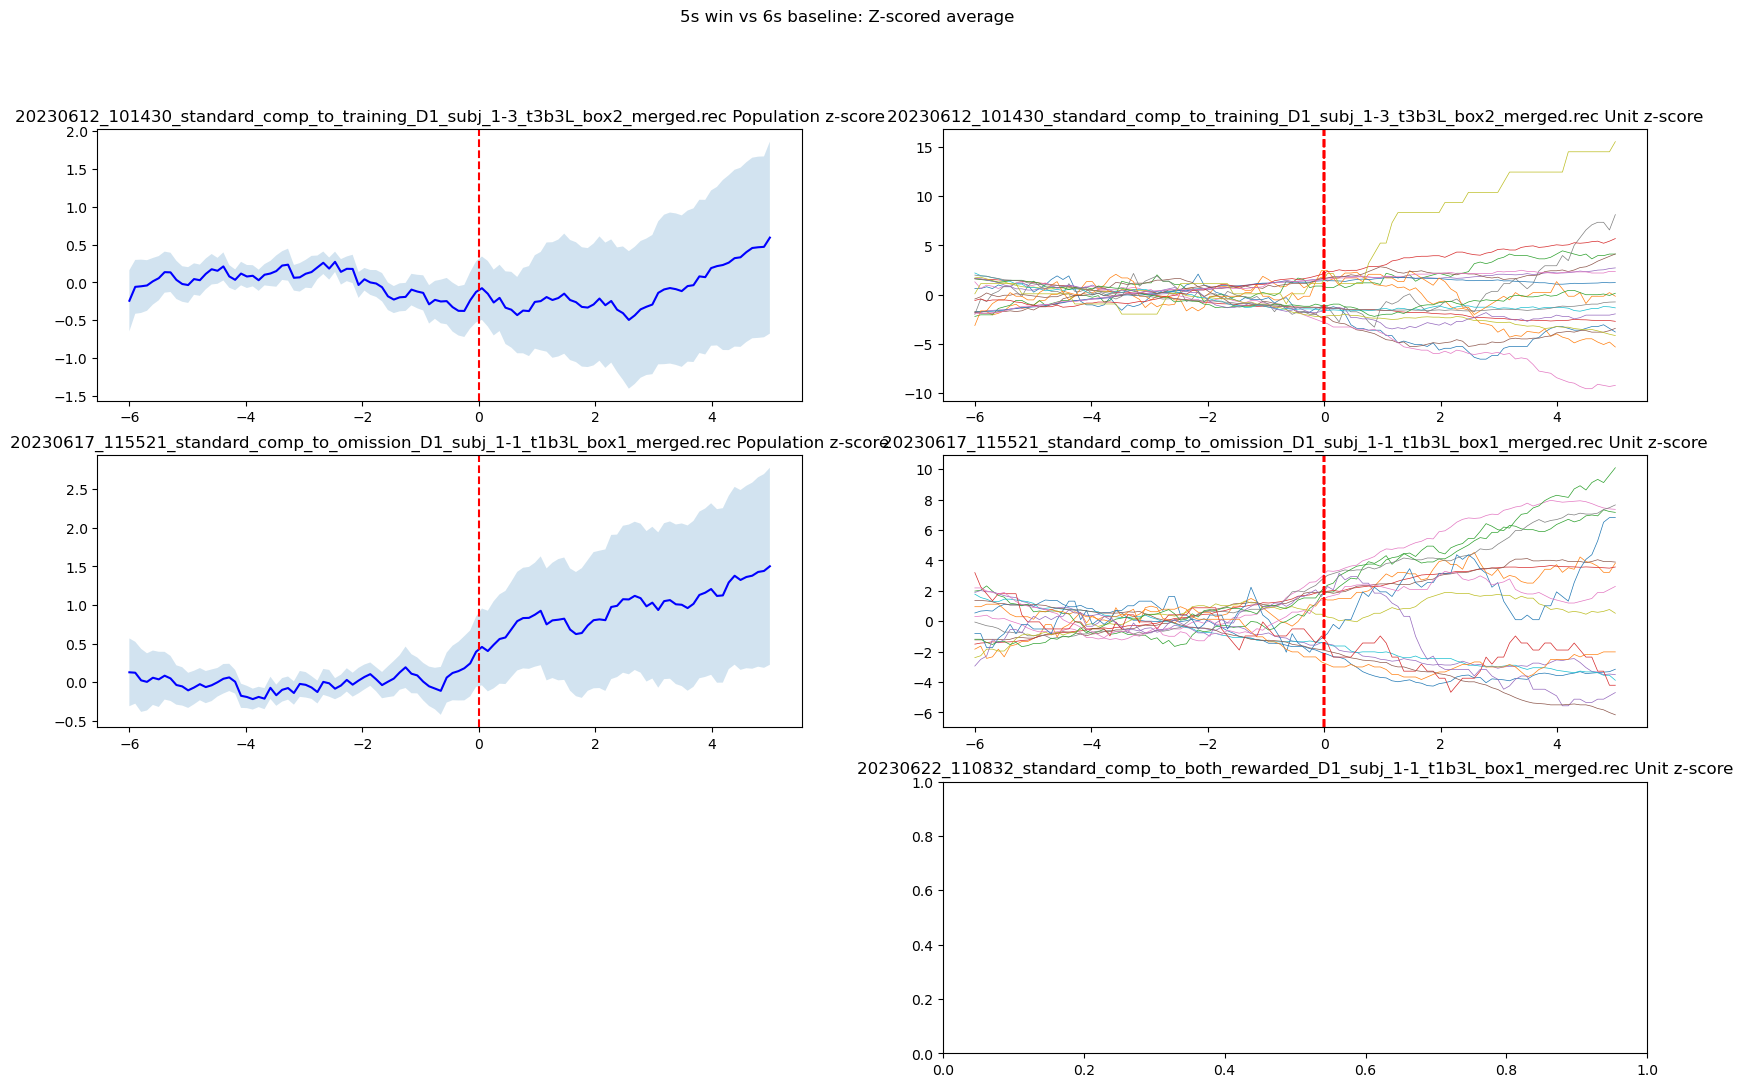

In [25]:
spike_analysis.zscore_pre_event(event='win', equalize=5, baseline_window=6)

Skipping population plot for 20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec due to insufficient data.


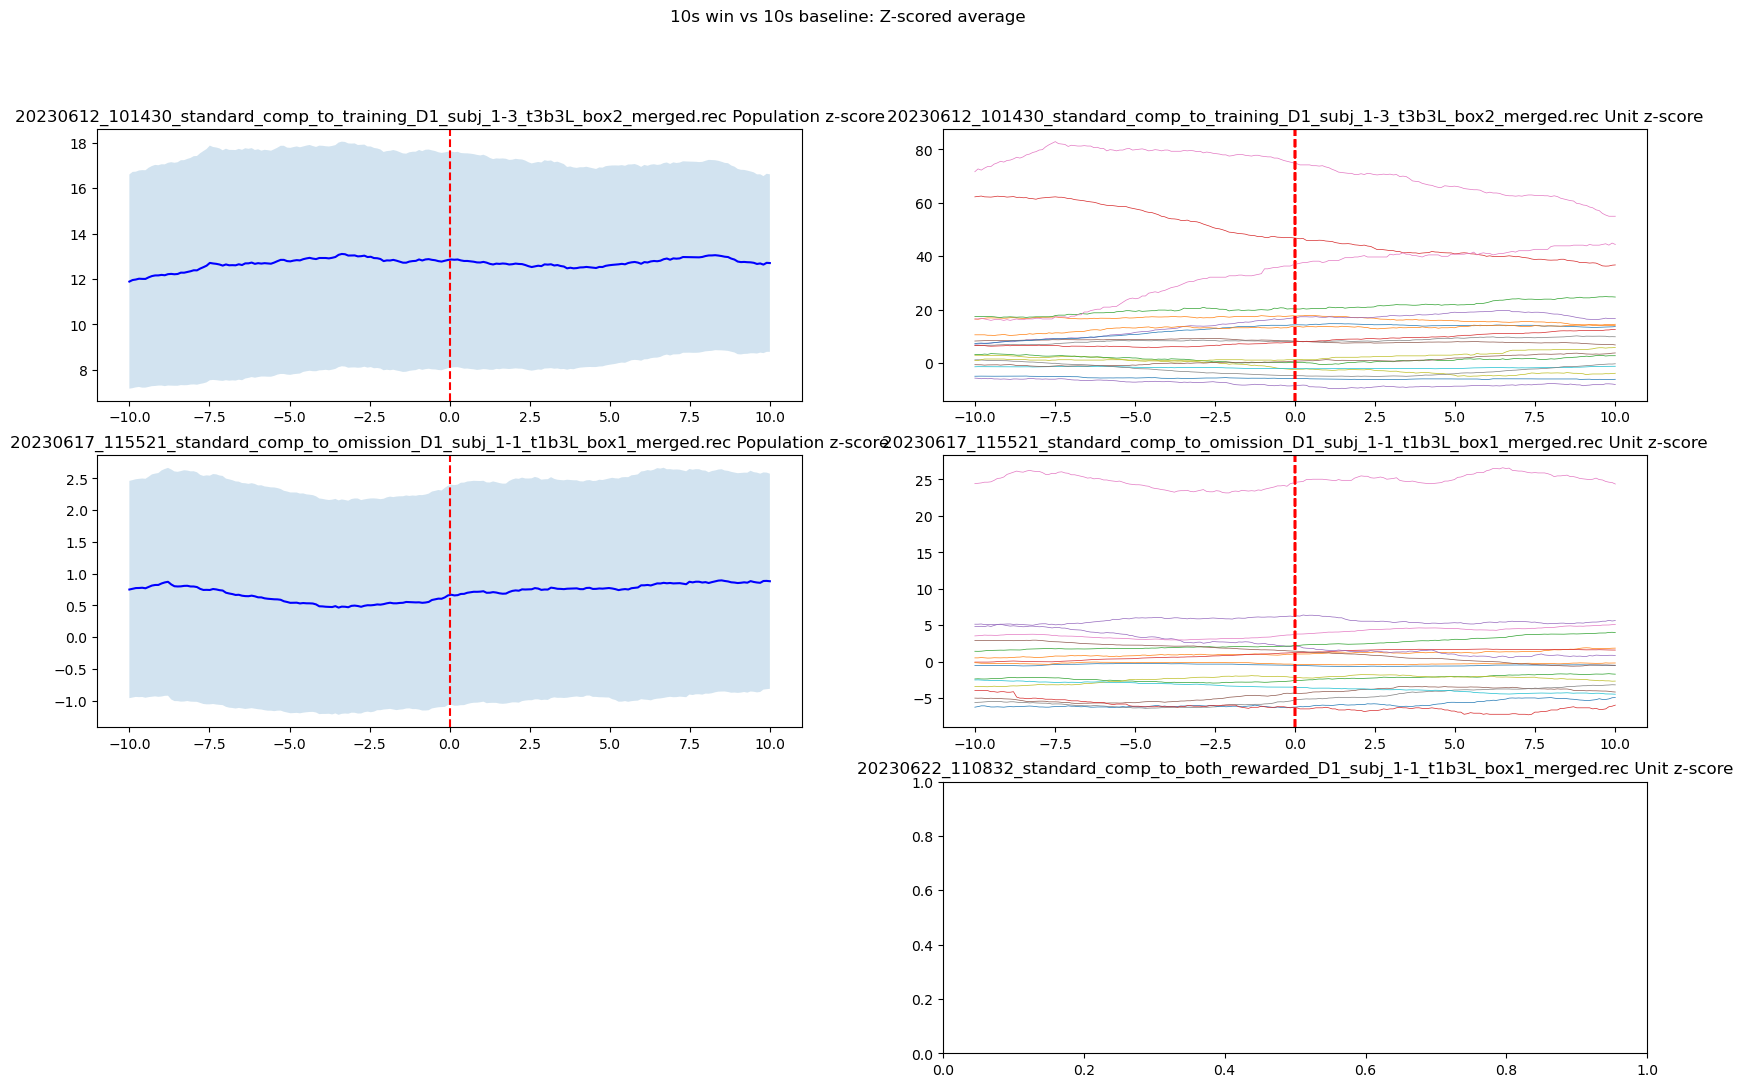

In [26]:
spike_analysis.zscore_baseline_event(event='win', baseline='lose', equalize=10, pre_window = 10)

In [27]:
spike_analysis2.zscore_pre_event(event='win', equalize=10, baseline_window=10)

NameError: name 'spike_analysis2' is not defined

In [28]:
spike_analysis2.zscore_pre_event(event='win', equalize=90, baseline_window=60)

NameError: name 'spike_analysis2' is not defined

In [29]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import multirecording_spikeanalysis as spike

cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)
        

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'test'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 92 is unsorted & has 2494 spikes
Unit 92 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec
Please assign event dictionaries to each recording
as recording.event_dict
event_dict = {event name(str): np.array[[start(ms), stop(ms)]...]
Please assign subjects to each recording as recording.subject


In [30]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


C:\Users\short\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=a

Unit 9 has NaN or zero sigma, skipping.
Unit 24 has NaN or zero sigma, skipping.
Unit 76 has NaN or zero sigma, skipping.
Unit 10 has NaN or zero sigma, skipping.
Unit 94 has NaN or zero sigma, skipping.
Unit 87 has NaN or zero sigma, skipping.
Unit 1 has NaN or zero sigma, skipping.
Unit 15 has NaN or zero sigma, skipping.
Unit 97 has NaN or zero sigma, skipping.
Unit 39 has NaN or zero sigma, skipping.
Unit 2 has NaN or zero sigma, skipping.
Unit 11 has NaN or zero sigma, skipping.
Unit 77 has NaN or zero sigma, skipping.
Skipping population plot for 20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec due to insufficient data.


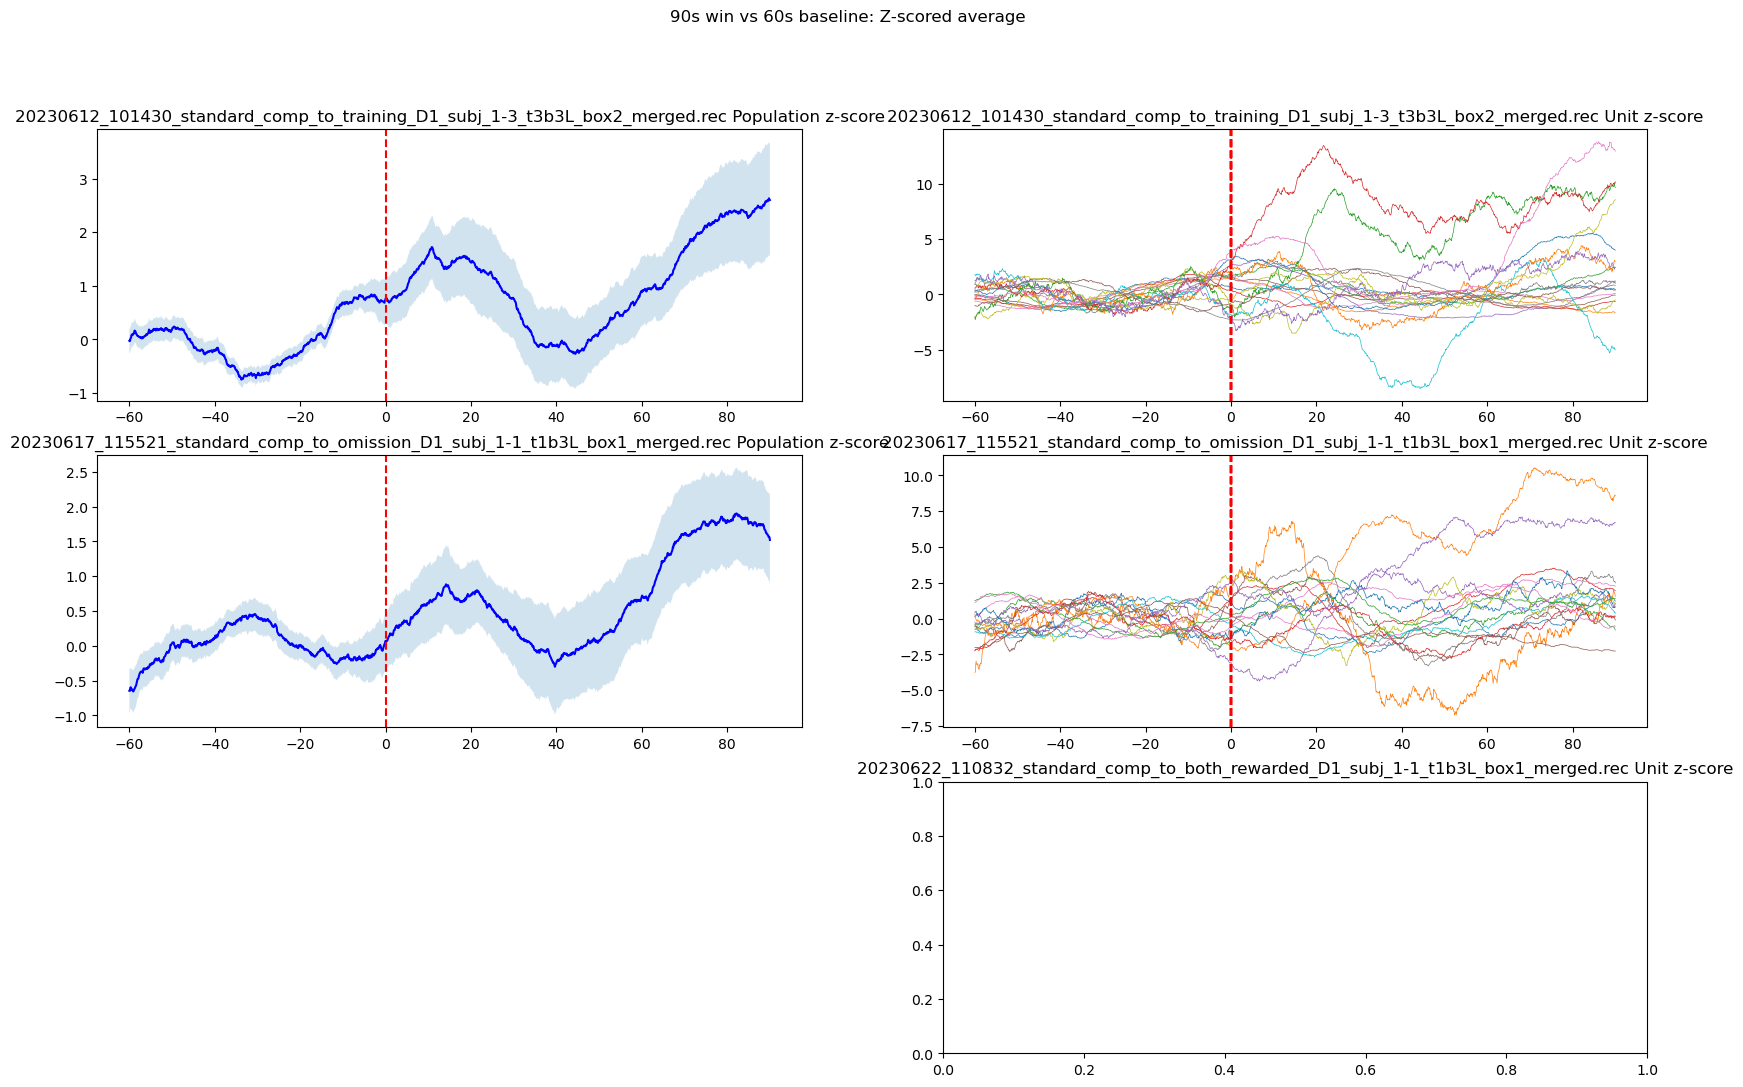

In [31]:
spike_analysis.zscore_pre_event(event='win', equalize=90, baseline_window=60)

In [32]:
wins_df = spike_analysis.zscore_pre_event(event='lose', equalize=10, baseline_window=10, offset = 0, plot = False, save = True)

In [33]:
wins_df

In [34]:
def analyze_neuron_significance(ephys_data, event_type='win', pre_window=10000, during_window=10000, z_score_threshold=3, z_score_suppression=-2):
    """
    Analyzes neuron significance based on z-scores for a given event.

    Args:
        ephys_data (SpikeAnalysis_MultiRecording): The ephys data analysis object.
        event_type (str): The type of event to analyze, e.g., 'win'.
        pre_window (int): The pre-event window duration in milliseconds.
        during_window (int): The during-event window duration in milliseconds.
        z_score_threshold (float): The z-score threshold for activation.
        z_score_suppression (float): The z-score threshold for suppression.

    Returns:
        A DataFrame with the percentage of neurons significantly activated or suppressed for each recording.
    """
    results = []

    for recording_name, recording in ephys_data.ephyscollection.collection.items():
        # Assume `zscore_pre_event` function exists within SpikeAnalysis_MultiRecording to calculate z-scores.
        # This hypothetical function should compare firing rates during an event to a pre-event baseline to produce z-scores.
        zscores_df = ephys_data.zscore_pre_event(event=event_type, equalize=during_window / 1000, baseline_window=pre_window / 1000, plot=False, save=False)

        # Filter the DataFrame for the current recording
        zscores_df_filtered = zscores_df[zscores_df['Recording'] == recording_name]

        # Calculate percentages
        activated = (zscores_df_filtered['Z-Score'] > z_score_threshold).mean() * 100
        suppressed = (zscores_df_filtered['Z-Score'] < z_score_suppression).mean() * 100

        results.append({
            'Recording': recording_name,
            'Percent Activated': activated,
            'Percent Suppressed': suppressed
        })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df


In [35]:
zscoredf = analyze_neuron_significance(ephys_data, event_type='win', pre_window=10000, during_window=10000, z_score_threshold=3, z_score_suppression=-2)

AttributeError: 'EphysRecordingCollection' object has no attribute 'ephyscollection'

C:\Users\short\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Skipping population plot for 20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec due to insufficient data.
Skipping population plot for 20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec due to insufficient data.


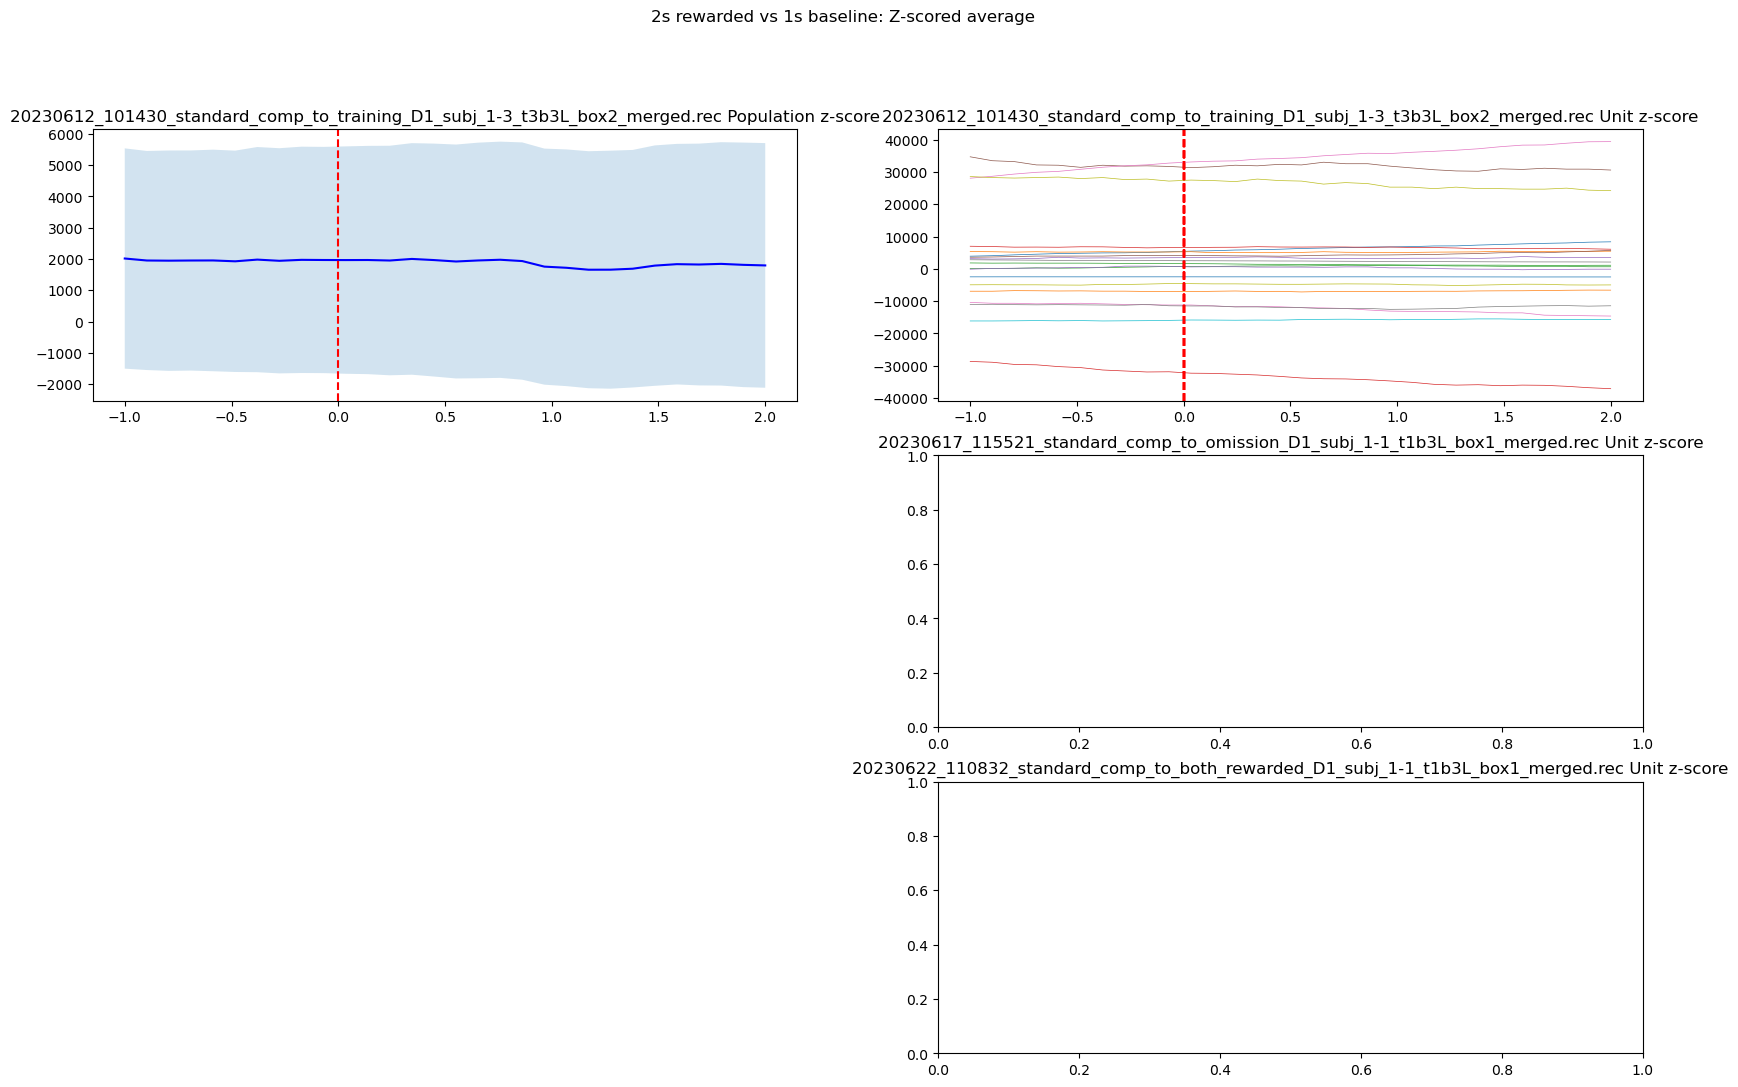

                                           Recording  \
0  20230612_101430_standard_comp_to_training_D1_s...   
1  20230612_101430_standard_comp_to_training_D1_s...   
2  20230612_101430_standard_comp_to_training_D1_s...   
3  20230612_101430_standard_comp_to_training_D1_s...   
4  20230612_101430_standard_comp_to_training_D1_s...   

                                    Event Subject  original unit id  \
0  2s rewarded w/ pre 1s vs global (1000)     1-3                85   
1  2s rewarded w/ pre 1s vs global (1000)     1-3                55   
2  2s rewarded w/ pre 1s vs global (1000)     1-3                17   
3  2s rewarded w/ pre 1s vs global (1000)     1-3                24   
4  2s rewarded w/ pre 1s vs global (1000)     1-3                68   

  Significance             0             1             2             3  \
0   inhibitory  -2479.817057  -2474.623038  -2469.429019  -2474.623038   
1   inhibitory  -6925.952454  -6925.952454  -6751.814105  -6786.641774   
2   excitatory

In [40]:
# Assuming you want to calculate z-scores for a specific event 'rewarded', with each event equalized to 2 seconds,
# including 1 second of pre-event data for z-scoring, and using a global baseline calculated in 1000 ms chunks:
event_name = 'rewarded'  # Example event name
equalize = 2  # seconds
pre_window = 1  # second
global_timebin = 1000  # milliseconds

# Calculate z-scores
zscore_df = spike_analysis.zscore_global(event=event_name, equalize=equalize, pre_window=pre_window, global_timebin=global_timebin, SD = 2, plot=True, save=False)

# Display the resulting DataFrame
print(zscore_df.head())

C:\Users\short\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\short\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Skipping population plot for 20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec due to insufficient data.
Skipping population plot for 20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec due to insufficient data.


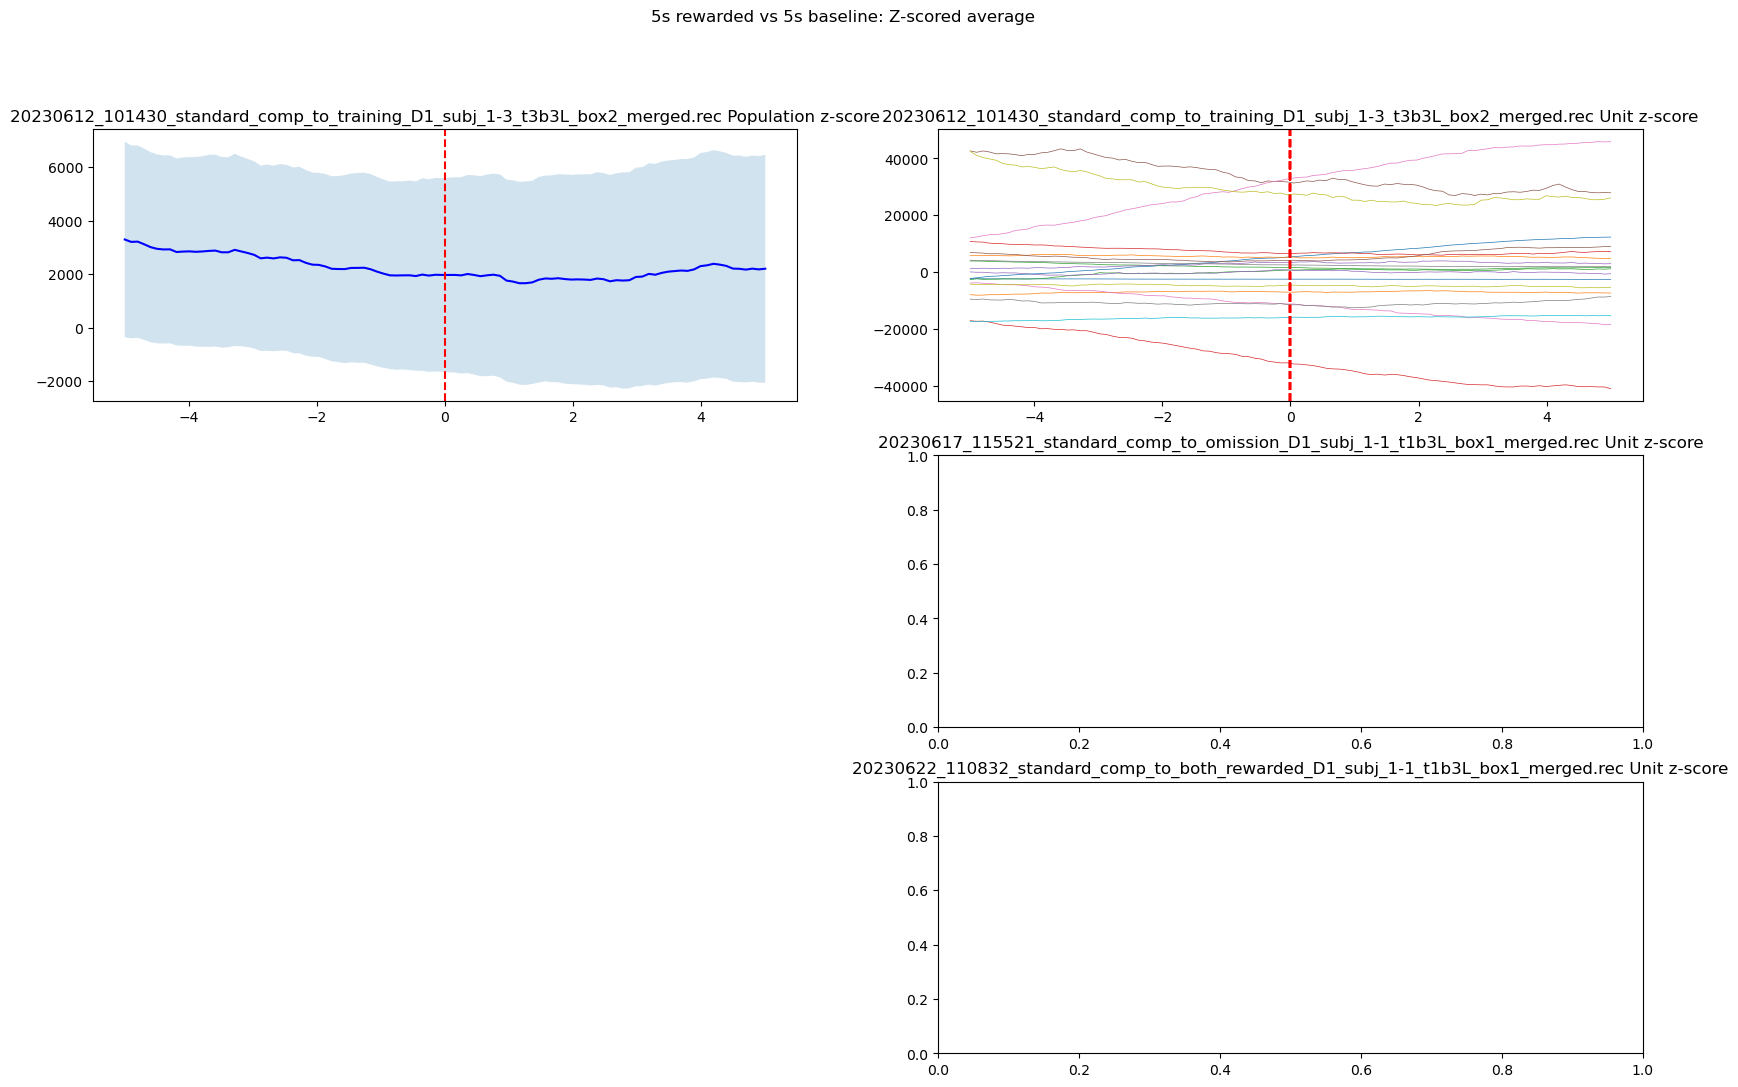

                                           Recording  \
0  20230612_101430_standard_comp_to_training_D1_s...   
1  20230612_101430_standard_comp_to_training_D1_s...   
2  20230612_101430_standard_comp_to_training_D1_s...   
3  20230612_101430_standard_comp_to_training_D1_s...   
4  20230612_101430_standard_comp_to_training_D1_s...   

                                    Event Subject  original unit id  \
0  5s rewarded w/ pre 5s vs global (1000)     1-3                85   
1  5s rewarded w/ pre 5s vs global (1000)     1-3                55   
2  5s rewarded w/ pre 5s vs global (1000)     1-3                17   
3  5s rewarded w/ pre 5s vs global (1000)     1-3                24   
4  5s rewarded w/ pre 5s vs global (1000)     1-3                68   

  Significance             0             1             2             3  \
0   inhibitory  -2344.772559  -2349.966578  -2349.966578  -2355.160597   
1   inhibitory  -7935.954883  -8110.093232  -8075.265562  -7935.954883   
2   excitatory

In [42]:
# Assuming you want to calculate z-scores for a specific event 'rewarded', with each event equalized to 2 seconds,
# including 1 second of pre-event data for z-scoring, and using a global baseline calculated in 1000 ms chunks:

# Calculate z-scores
zscore_df = spike_analysis.zscore_global(event='rewarded', equalize=5, pre_window=5, global_timebin=1000, SD=2, plot=True, save=False)

# Display the resulting DataFrame
print(zscore_df.head())

In [43]:
import spikeanal as spikeredo